<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Logo.png" alt="Instill Logo" width="300"/>

# Get Your PDF Files AI-Ready

In this notebook, we will run **Instill VDP** pipelines hosted on the **Instill Cloud** platform to parse PDF files into high-quality markdown formatted text, suitable for AI applications. It will include the following sections:

1. Transform PDF (or any of PDF/DOCX/DOC/PPTX/PPT/HTML/XLSX) documents into markdown using the **Instill Component** [Document Operator](https://www.instill.tech/docs/component/operator/document#convert-to-markdown).
2. Use a Visual Langauge Model (VLM) to process PDF files into high quality markdown content that contains complex tables, detailed image summaries.
3. Upload and Process markdown files to **Instill Catalog**.

### Setup

To execute all of the code in this notebook, you’ll need to create a free Instill Cloud account and setup an API Token. To create your account, please refer to our [quickstart guide](https://www.instill.tech/docs/quickstart). For generating your API Token, consult the [API Token Management](https://www.instill.tech/docs/core/token) page.

**This will give you access to 10,000 free credits per month that you can use to make API calls with third-party AI vendors. Please see our [documentation](https://www.instill.tech/docs/cloud/credit) for further details.**

In [6]:
!pip install instill-sdk==0.11.0 --quiet

In [22]:
from IPython.display import IFrame, Markdown, display, HTML

display(HTML('''
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:400px;  /* Change this to adjust the maximum height */
    overflow-y:auto;
}
</style>
'''))

import base64
import requests

from instill.clients.client import init_pipeline_client
#pipeline = init_pipeline_client(api_token="YOUR_INSTILL_API_TOKEN")

import os
pipeline = init_pipeline_client(api_token=os.getenv("INSTILL_API_TOKEN"))

In [20]:
def encode(file_path_or_url):
    # if the file is a URL, download it
    if file_path_or_url.startswith("http://") or file_path_or_url.startswith("https://"):
        response = requests.get(file_path_or_url)
        file_content = response.content

    # if the file is a local file, read it
    else:
        with open(file_path_or_url, "rb") as file:
            file_content = file.read()

    # encode the file
    encoded_file = base64.b64encode(file_content).decode('utf-8')
    return encoded_file


def get_md(response):
    return response.outputs[0].fields['markdown'].string_value


def print_md(markdown_text):
    display(Markdown(markdown_text))

In [25]:
response = pipeline.trigger_namespace_pipeline(
    "george_strong",
    "standard-doc-to-markdown",
    [{"file": encode("/Users/georgestrong/Desktop/test.pdf")}]
)

In [26]:
md_text = get_md(response)
print_md(md_text)



CYCOLOY™ RESIN C1200HF<br>REGION ASIA<br>DESCRIPTION<br>PC+ABS, excellent flow/impact/high heat resistance. Low temperature ductility.<br>TYPICAL PROPERTY VALUES Revision 2019081 | |||
| --- | --- | --- | --- |
PROPERTIES | TYPICAL VALUES | UNITS | TEST METHODS
MECHANICAL | |||
Tensile Stress, yld, Type I, 50 mm/min 57 MPa ASTM D638 | |||
Tensile Strain, yld, Type I, 50 mm/min 5 % ASTM D638 | |||
Tensile Strain, brk, Type I, 50 mm/min 100 % ASTM D638 | |||
Tensile Modulus, 50 mm/min 2270 MPa ASTM D638 | |||
Flexural Stress, yld, 1.3 mm/min, 50 mm span 88 MPa ASTM D790 | |||
Flexural Modulus, 1.3 mm/min, 50 mm span 2340 MPa ASTM D790 | |||
IMPACT | |||
Izod Impact, notched, 23°C 587 J/m ASTM D256 | |||
Izod Impact, notched, -30°C 480 J/m ASTM D256 | |||
Instrumented Dart Impact Total Energy, 23°C 54 J ASTM D3763 | |||
Instrumented Dart Impact Total Energy, -30°C 54 J ASTM D3763 | |||
THERMAL | |||
HDT, 0.45 MPa, 3.2 mm, unannealed 129 °C ASTM D648 | |||
HDT, 1.82 MPa, 3.2mm, unannealed 112 °C ASTM D648 | |||
CTE, -40°C to 40°C, flow 7.2E-05 1/°C ASTM E831 | |||
Vicat Softening Temp, Rate B/50 130 °C ISO 306 | |||
Relative Temp Index, Elec 105 °C UL 746B | |||
Relative Temp Index, Mech w/impact 80 °C UL 746B | |||
Relative Temp Index, Mech w/o impact 105 °C UL 746B | |||
PHYSICAL | |||
Specific Gravity 1.15 - ASTM D792 | |||
Mold Shrinkage, flow, 3.2 mm 0.5 – 0.7 % SABIC method | |||
Melt Flow Rate, 260°C/5.0 kgf 19 g/10 min ASTM D1238 | |||
ELECTRICAL | |||
Hot Wire Ignition {PLC) 3 PLC Code UL 746A | |||
High Ampere Arc Ign, surface {PLC} 1 PLC Code UL 746A | |||
Comparative Tracking Index (UL) {PLC} 2 PLC Code UL 746A | |||
FLAME CHARACTERISTICS | |||
UL Yellow Card Link E207780-228463 - - | |||
UL Yellow Card Link 2 E45587-236932 - - | |||
UL Recognized, 94HB Flame Class Rating 1.19 mm UL 94 | |||
INJECTION MOLDING | |||
Drying Temperature 100 – 110 °C | |||
Drying Time 3 – 4 Hrs | |||
Drying Time (Cumulative) 8 Hrs | |||
©M 20ax2i3m Cuompy Mrigohits tbuyr SeA CBoICn. tAelln rtights reserved 0.02 % | |||
Melt Temperature 275 – 300 °C | |||
Nozzle Temperature 275 – 300 °C | |||
Front - Zone 3 Temperature 260 – 300 °C | |||
Middle - Zone 2 Temperature 255 – 295 °C | |||
Rear - Zone 1 Temperature 250 – 290 °C | |||
Hopper Temperature 60 – 80 °C | |||
Mold Temperature 60 – 90 °C | |||
Back Pressure 0.3 – 0.7 MPa | |||
Screw Speed 40 – 70 rpm | |||
Shot to Cylinder Size 30 – 80 % | |||
Vent Depth 0.038 – 0.076 mm<br>DISCLAIMER<br>Any sale by SABIC, its subsidiaries and affiliates (each a “seller”), is made exclusively under seller’s standard conditions of sale (available upon request) unless agreed<br>otherwise in writing and signed on behalf of the seller. While the information contained herein is given in good faith, SELLER MAKES NO WARRANTY, EXPRESS OR IMPLIED,<br>INCLUDING MERCHANTABILITY AND NONINFRINGEMENT OF INTELLECTUAL PROPERTY, NOR ASSUMES ANY LIABILITY, DIRECT OR INDIRECT, WITH RESPECT TO THE<br>PERFORMANCE, SUITABILITY OR FITNESS FOR INTENDED USE OR PURPOSE OF THESE PRODUCTS IN ANY APPLICATION. Each customer must determine the suitability of selle<br>materials for the customer’s particular use through appropriate testing and analysis. No statement by seller concerning a possible use of any product, service or design is<br>intended, or should be construed, to grant any license under any patent or other intellectual property right. | |||



CYCOLOY™ RESIN C1200HF<br>REGION ASIA<br>DESCRIPTION<br>PC+ABS, excellent flow/impact/high heat resistance. Low temperature ductility.<br>TYPICAL PROPERTY VALUES Revision 20190814 | ||||
| --- | --- | --- | --- | --- |
PROPERTIES | TYPICAL VALUES | UNITS | TEST METHODS | |
MECHANICAL | ||||
Tensile Stress, yld, Type I, 50 mm/min 57 MPa ASTM D638 | ||||
Tensile Strain, yld, Type I, 50 mm/min 5 % ASTM D638 | ||||
Tensile Strain, brk, Type I, 50 mm/min 100 % ASTM D638 | ||||
Tensile Modulus, 50 mm/min 2270 MPa ASTM D638 | ||||
Flexural Stress, yld, 1.3 mm/min, 50 mm span 88 MPa ASTM D790 | ||||
Flexural Modulus, 1.3 mm/min, 50 mm span 2340 MPa ASTM D790 | ||||
IMPACT | ||||
Izod Impact, notched, 23°C 587 J/m ASTM D256 | ||||
Izod Impact, notched, -30°C 480 J/m ASTM D256 | ||||
Instrumented Dart Impact Total Energy, 23°C 54 J ASTM D3763 | ||||
Instrumented Dart Impact Total Energy, -30°C 54 J ASTM D3763 | ||||
THERMAL | ||||
HDT, 0.45 MPa, 3.2 mm, unannealed 129 °C ASTM D648 | ||||
HDT, 1.82 MPa, 3.2mm, unannealed 112 °C ASTM D648 | ||||
CTE, -40°C to 40°C, flow 7.2E-05 1/°C ASTM E831 | ||||
Vicat Softening Temp, Rate B/50 130 °C ISO 306 | ||||
Relative Temp Index, Elec 105 °C UL 746B | ||||
Relative Temp Index, Mech w/impact 80 °C UL 746B | ||||
Relative Temp Index, Mech w/o impact 105 °C UL 746B | ||||
PHYSICAL | ||||
Specific Gravity 1.15 - ASTM D792 | ||||
Mold Shrinkage, flow, 3.2 mm 0.5 – 0.7 % SABIC method | ||||
Melt Flow Rate, 260°C/5.0 kgf 19 g/10 min ASTM D1238 | ||||
||||||
ELECTRICAL | ||||
Hot Wire Ignition {PLC) 3 PLC Code UL 746A | ||||
High Ampere Arc Ign, surface {PLC} 1 PLC Code UL 746A | ||||
Comparative Tracking Index (UL) {PLC} 2 PLC Code UL 746A | ||||
FLAME CHARACTERISTICS | ||||
UL Yellow Card Link E207780-228463 - - | ||||
UL Yellow Card Link 2 E45587-236932 - - | ||||
||||||
UL Recognized, 94HB Flame Class Rating 1.19 mm UL 94 | ||||
INJECTION MOLDING | ||||
Drying Temperature | 100 – 110 | °C | ||
PROPERTIES<br>Drying Time | TYPICAL VALUES<br>3 – 4 | UNITS<br>Hrs | TEST METHODS | |
Drying Time (Cumulative) 8 Hrs | ||||
Maximum Moisture Content 0.02 % | ||||
Melt Temperature 275 – 300 °C | ||||
Nozzle Temperature 275 – 300 °C | ||||
Front - Zone 3 Temperature 260 – 300 °C | ||||
Middle - Zone 2 Temperature 255 – 295 °C | ||||
Rear - Zone 1 Temperature 250 – 290 °C | ||||
Hopper Temperature 60 – 80 °C | ||||
Mold Temperature 60 – 90 °C | ||||
Back Pressure 0.3 – 0.7 MPa | ||||
Screw Speed 40 – 70 rpm | ||||
Shot to Cylinder Size 30 – 80 % | ||||
Vent Depth 0.038 – 0.076 mm<br>DISCLAIMER<br>Any sale by SABIC, its subsidiaries and affiliates (each a “seller”), is made exclusively under seller’s standard conditions of sale (available upon request) unless agreed<br>otherwise in writing and signed on behalf of the seller. While the information contained herein is given in good faith, SELLER MAKES NO WARRANTY, EXPRESS OR IMPLIED,<br>INCLUDING MERCHANTABILITY AND NONINFRINGEMENT OF INTELLECTUAL PROPERTY, NOR ASSUMES ANY LIABILITY, DIRECT OR INDIRECT, WITH RESPECT TO THE<br>PERFORMANCE, SUITABILITY OR FITNESS FOR INTENDED USE OR PURPOSE OF THESE PRODUCTS IN ANY APPLICATION. Each customer must determine the suitability of seller<br>materials for the customer’s particular use through appropriate testing and analysis. No statement by seller concerning a possible use of any product, service or design is<br>intended, or should be construed, to grant any license under any patent or other intellectual property right. | ||||
||||||
© 2023 Copyright by SABIC. All rights reserved | ||||



In [27]:
response = pipeline.trigger_namespace_pipeline(
    "george_strong",
    "vlm-pdf-to-markdown",
    [{"file": encode("/Users/georgestrong/Desktop/test.pdf")}]
)

In [28]:
image = response.outputs[0].fields['images'].list_value.values[1].string_value


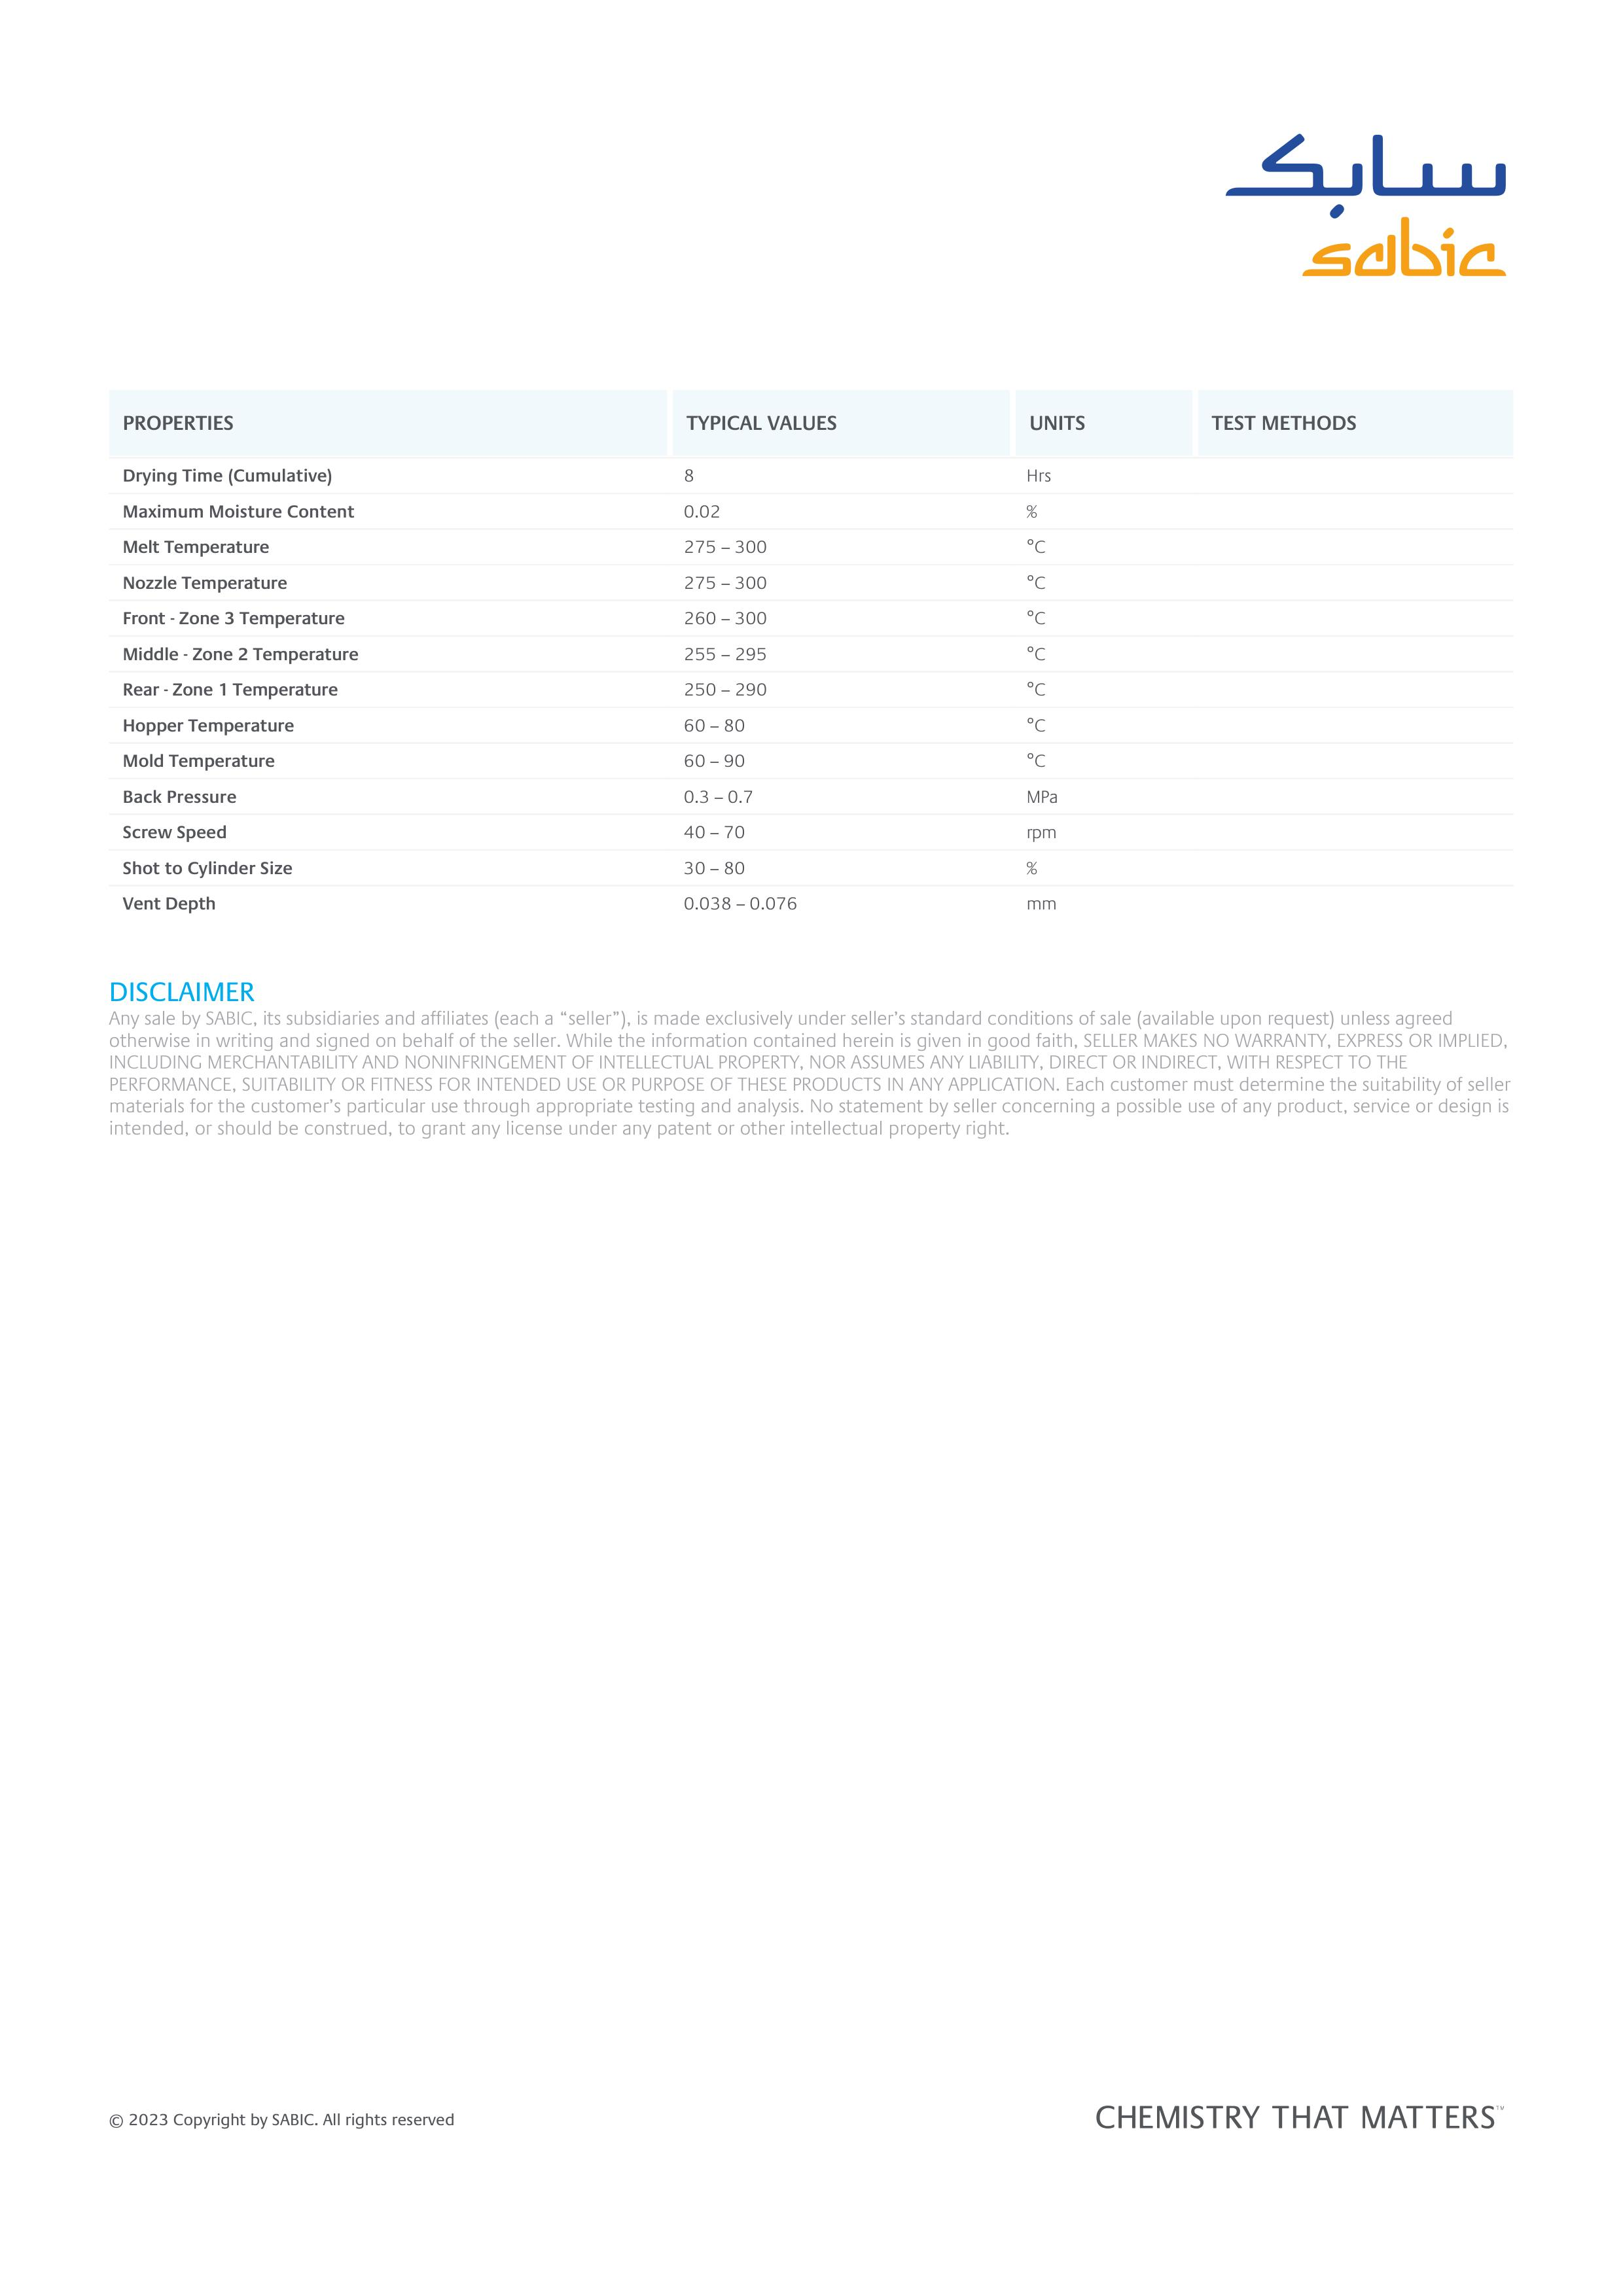

In [29]:
img_tag = f'<img src="{image}" width="600"/>'
display(HTML(img_tag))

In [30]:
md_text = get_md(response)
print_md(md_text)

# CYCLOLOY™ RESIN C1200HF
## REGION ASIA

### DESCRIPTION
PC+ABS, excellent flow/impact/high heat resistance. Low temperature ductility.

### TYPICAL PROPERTY VALUES
| PROPERTIES                          | TYPICAL VALUES | UNITS | TEST METHODS  |
|-------------------------------------|----------------|-------|---------------|
| **MECHANICAL**                      |                |       |               |
| Tensile Stress, yld, Type I, 50 mm/min | 57             | MPa   | ASTM D638     |
| Tensile Strain, yld, Type I, 50 mm/min | 5              | %     | ASTM D638     |
| Tensile Strain, brk, Type I, 50 mm/min | 100            | %     | ASTM D638     |
| Tensile Modulus, 50 mm/min         | 2270           | MPa   | ASTM D638     |
| Flexural Stress, yld, 1.3 mm/min, 50 mm span | 88         | MPa   | ASTM D790     |
| Flexural Modulus, 1.3 mm/min, 50 mm span | 2340         | MPa   | ASTM D790     |
| **IMPACT**                          |                |       |               |
| Izod Impact, notched, 23°C         | 587            | J/m   | ASTM D256     |
| Izod Impact, notched, -30°C        | 480            | J/m   | ASTM D256     |
| Instrumented Dart Impact Total Energy, 23°C | 54       | J     | ASTM D3763    |
| Instrumented Dart Impact Total Energy, 30°C | 54       | J     | ASTM D3763    |
| **THERMAL**                        |                |       |               |
| HDT, 0.45 MPa, 3.2 mm, unannealed  | 129            | °C    | ASTM D648     |
| HDT, 1.82 MPa, 3.2 mm, unannealed  | 112            | °C    | ASTM D648     |
| CTE, -40°C to 40°C, flow           | 7.2E-05        | 1/°C  | ASTM E831     |
| Vicat Softening Temp, Rate B/50    | 130            | °C    | ISO 306       |
| Relative Temp Index, Elec          | 105            | °C    | UL 746B       |
| Relative Temp Index, Mech w/impact  | 80             | °C    | UL 746B       |
| Relative Temp Index, Mech w/o impact | 105           | °C    | UL 746B       |
| **PHYSICAL**                        |                |       |               |
| Specific Gravity                    | 1.15           | -     | ASTM D792     |
| Mold Shrinkage, flow, 3.2 mm       | 0.5 – 0.7      | %     | SABIC method   |
| Melt Flow Rate, 260°C/5.0 kgf      | 19             | g/10 min | ASTM D1238  |
| **ELECTRICAL**                     |                |       |               |
| Hot Wire Ignition (PLC)            | 3              | PLC Code | UL 746A     |
| High Amper Arc Ign, surface (PLC)  | 1              | PLC Code | UL 746A     |
| Comparative Tracking Index (UL) (PLC) | 2            | PLC Code | UL 746A     |
| **FLAME CHARACTERISTICS**          |                |       |               |
| UL Yellow Card Link                 | E207780-228463  | -     | -             |
| UL Yellow Card Link 2               | E45587-236932   | -     | -             |
| UL Recognized, 94HB Flame Class Rating | 1.19        | mm    | UL 94         |
| **INJECTION MOLDING**              |                |       |               |
| Drying Temperature                  | 100 – 110      | °C    |               |
| Drying Time                         | 3 – 4          | Hrs   |               |

---

## DISCLAIMER
Any sale by SABIC, its subsidiaries and affiliates (each a "seller"), is made exclusively under seller's standard conditions of sale (available upon request) unless agreed otherwise in writing and signed on behalf of the seller. While the information contained herein is given in good faith, SELLER MAKES NO WARRANTY, EXPRESS OR IMPLIED, INCLUDING MERCHANTABILITY AND NONINFRINGEMENT OF INTELLECTUAL PROPERTY, NOR ASSUMES ANY LIABILITY, DIRECT OR INDIRECT, WITH RESPECT TO THE PERFORMANCE, SUITABILITY OR FITNESS FOR INTENDED USE OR PURPOSE OF THESE PRODUCTS IN ANY APPLICATION. Each customer must determine the suitability of seller materials for the customer's particular use through appropriate testing and analysis. No statement by seller concerning a possible use of any product, service or design is intended, or should be construed, to grant any license under any patent or other intellectual property right.

In [10]:
pdf1 = "/Users/georgestrong/Documents/demo/caleus/sample_data 1/pdf1/10 CFR Part 51 (up to date as of 8-30-2024).pdf"
pdf2 = "/Users/georgestrong/Documents/demo/caleus/sample_data 1/pdf1/50 CFR Part 10 (up to date as of 8-30-2024).pdf"

In [11]:
response = pipeline.trigger_namespace_pipeline(
    "george_strong",
    "standard-doc-to-markdown",
    [{"file": encode(pdf2)}]
)

In [ ]:
md_text = get_md(response)
print_md(md_text)

In [ ]:
print(md_text)

In [ ]:
!pip install pymupdf


In [17]:
import fitz  # PyMuPDF
import base64
from io import BytesIO

In [18]:
# Define file path and group size
group_size = 5 # Number of pages per group

# Load the PDF
pdf_document = fitz.open(pdf2)
num_pages = len(pdf_document)

In [19]:
encoded_groups = []

for i in range(0, num_pages, group_size):
    end_page = min(i + group_size, num_pages)
    
    # Extract pages
    pdf_writer = fitz.open()  # New PDF for each group
    for page_num in range(i, end_page):
        pdf_writer.insert_pdf(pdf_document, from_page=page_num, to_page=page_num)
    
    # Save to BytesIO
    pdf_bytes = BytesIO()
    pdf_writer.save(pdf_bytes)
    pdf_writer.close()
    
    # Base64 encode
    encoded_pdf = base64.b64encode(pdf_bytes.getvalue()).decode('utf-8')
    encoded_groups.append(encoded_pdf)

In [20]:
from tqdm import tqdm

In [ ]:
responses = []

for encoded_group in tqdm(encoded_groups, desc="Processing Groups"):
    response = pipeline.trigger_namespace_pipeline(
        "george_strong",
        "vlm-pdf-to-markdown",
        [{"file": encoded_group}]
    )
    
    # Append the response to the list
    responses.append(response)

In [19]:
# Initialize an empty string to hold the entire markdown content
merged_markdown = ""

# Iterate over the responses and concatenate the markdown content
for response in responses:
    markdown_content = response.outputs[0].fields['markdown'].string_value
    merged_markdown += markdown_content + "\n"

In [ ]:
print_md(merged_markdown)